<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4b_predict_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 4b - Predict on new data

This is step 4b of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to make predictions on a novel video.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

If you're using Colab make sure to go to the “Runtime” dropdown menu, select “change runtime type” and select GPU in the hardware accelerator drop-down menu

If you haven't already installed DeepPoseKit you can run the next cell

In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/jgraving/deepposekit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, VideoReader, VideoWriter

import tqdm
import time
from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

Use the next cell to download the example data into your home directory

In [ ]:
!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

Find the saved models

In [4]:
models = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*model*.h5'))
models

['/Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [5]:
model = load_model(HOME + '/deepposekit-data/datasets/fly/best_model_densenet.h5')

W0929 11:47:15.342607 4653290944 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 11:47:15.344443 4653290944 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 11:47:15.368042 4653290944 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorf

Find the available videos

In [6]:
videos = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*video.avi'))
videos

['/Users/jake/deepposekit-data/datasets/fly/video.avi']

# Test the video

Check to make sure `VideoReader` is correctly loading the video frames

In [7]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/fly/video.avi', batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

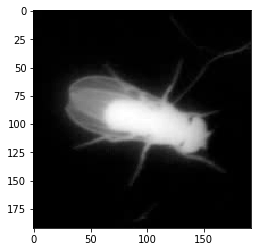

In [8]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

# Makes predictions for the full video

This loads batches of frames and makes predictions. This was run on the CPU as an example so it's a bit slow, but on the GPU it's much faster.


In [9]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/fly/video.avi', batch_size=50, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()


675/675 [==============================] - 1005s 1s/step


True

This splits the predictions into their row coordinates (y-axis), column coordinates (x-axis), and confidence scores from each confidence map.

In [10]:
row, col, confidence = np.split(predictions, 3, -1)

Plot the confidence scores

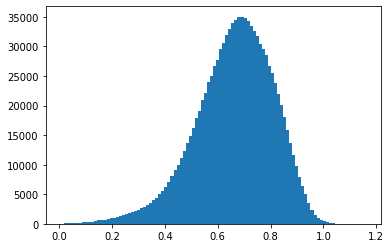

In [11]:
plt.hist(confidence.flatten(), bins=100)
plt.show()

# Save the data

Once you have your predictions you can save it however you wish. Here is an example using numpy.save

In [12]:
np.save(HOME + '/deepposekit-data/datasets/fly/predictions.npy', predictions)

# Visualize the data

This is an example of how to visualize the predicted posture data on the original video.

In [16]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5')
predictions = predictions[...,:2]
predictions *= (160./192.)
predictions *= 3

/usr/local/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [19]:
# TODO: Turn this into a function
cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255

writer = VideoWriter(HOME + '/fly_posture.mp4', (160*3,160*3), 'MP4V', 30.0)
reader = VideoReader(videos[0], batch_size=1, gray=True)

for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    frame = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame = cv2.resize(frame, (160*3, 160*3))
    frame = cv2.bitwise_not(frame)
    original_frame = frame.copy()
    for idx, node in enumerate(data_generator.graph):
        if node >= 0:
            pt1 = keypoints[idx]
            pt2 = keypoints[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, keypoint in enumerate(keypoints):
        keypoint = keypoint.astype(int)
        cv2.circle(frame, (keypoint[0], keypoint[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)

writer.close()
reader.close()

33749it [01:08, 495.75it/s]


True

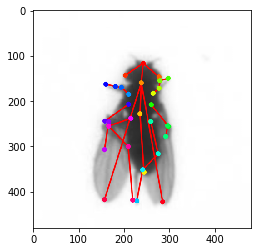

In [20]:
plt.imshow(frame[...,::-1])
plt.show()

In [ ]:
# TODO: Add code for selecting and merging new data